In [1]:
#Imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
 
sns.set(style="whitegrid")
np.random.seed(42)


In [2]:
def clean_and_normalize(df, label_col=None, normalize=True):
    dfc = df.copy()

    # If label col not given -> assume last
    if label_col is None:
        label_col = dfc.columns[-1]

    # Remove ID-like columns
    for col in list(dfc.columns):
        if (
            dfc[col].dtype == object 
            and dfc[col].nunique() == dfc.shape[0] 
            and col != label_col
        ):
            dfc = dfc.drop(columns=[col])

    # Fill missing values safely (NO inplace)
    for col in dfc.columns:
        if dfc[col].dtype == object:
            dfc[col] = dfc[col].fillna(dfc[col].mode()[0])
        else:
            dfc[col] = dfc[col].fillna(dfc[col].median())

    # Separate X, y
    X_df = dfc.drop(columns=[label_col])
    y_df = dfc[label_col]

    # Encode categorical features
    for col in X_df.columns:
        if X_df[col].dtype == object:
            X_df[col] = LabelEncoder().fit_transform(X_df[col])

    # Encode label
    if y_df.dtype == object:
        y_df = LabelEncoder().fit_transform(y_df)
    else:
        y_df = y_df.values

    # Normalization check
    if normalize:
        num_cols = X_df.select_dtypes(include=[np.number]).columns
        mins = X_df[num_cols].min()
        maxs = X_df[num_cols].max()

        is_norm = np.all((mins >= 0.0) & (maxs <= 1.0))

        if not is_norm:
            scaler = MinMaxScaler()
            X_df[num_cols] = scaler.fit_transform(X_df[num_cols])

    return X_df.values.astype(float), np.array(y_df)


In [3]:
#LDGBG implementation
class LDGBG:
    def __init__(self, g=1.0, sparsity_threshold=40.0, target_fraction=0.015):
        self.g = float(g)
        self.sparsity_threshold = float(sparsity_threshold)
        self.target_fraction = float(target_fraction)
        self.granular_balls = []
        self.delta_ = None
        self.dc_ = None

    # compute dc by scanning distances to satisfy avg neighbors ~ target_fraction*n
    def _compute_dc(self, X):
        N = len(X)
        D = cdist(X, X)
        flat = np.sort(D[np.triu_indices(N, k=1)])
        if len(flat) == 0:
            return 1e-6
        desired = max(1, int(self.target_fraction * N))
        best_dc = None
        best_err = float('inf')
        # scan candidate distances (use subset of percentiles for speed)
        ps = np.linspace(1, 99, 99)
        for p in ps:
            dc = np.percentile(flat, p)
            neighbors = (D <= dc).sum(axis=1) - 1  # exclude self
            avg = neighbors.mean()
            err = abs(avg - desired)
            if err < best_err:
                best_err = err
                best_dc = dc
        if best_dc is None:
            best_dc = np.percentile(flat, 2.0)
        return float(best_dc)

    # local density (rho) as gaussian sum + neighbor count
    def _local_density(self, X, delta):
        D = cdist(X, X)
        gaussian = np.exp(- (D / (delta + 1e-12)) ** 2)
        neighbors = (D <= delta).astype(float)
        rho = gaussian.sum(axis=1) + neighbors.sum(axis=1)
        return rho, D

    # outlier rule
    def _is_outlier(self, rho_i, rho_max, neigh_count, is_sparse):
        if not is_sparse and neigh_count <= 1:
            return True
        if rho_i < 0.01 * rho_max:
            return True
        return False

    # generate centers per class(density peaks, mark neighbors used)
    def _generate_centers_for_class(self, Xc, delta, is_sparse):
        if Xc.shape[0] == 0:
            return [], []
        rho, D = self._local_density(Xc, delta)
        rho_max = rho.max()
        used = np.zeros(len(Xc), dtype=bool)
        centers = []
        densities = []
        # iterate by density descending
        for idx in np.argsort(rho)[::-1]:
            if used[idx]:
                continue
            neigh_mask = (D[idx] <= delta)
            neigh_count = neigh_mask.sum()
            if self._is_outlier(rho[idx], rho_max, neigh_count, is_sparse):
                used[idx] = True
                rho[idx] = 0.0
                continue
            # select center
            centers.append(Xc[idx])
            densities.append(rho[idx])
            # zero densities for center & neighbors
            rho[neigh_mask] = 0.0
            used[neigh_mask] = True
        return centers, densities

    # radius computation
    def _compute_radii(self, centers, labels, dens, delta):
        if len(centers) == 0:
            return np.array([])
        C = np.array(centers)
        if len(C) == 1:
            return np.array([delta / 2.0])
        D = cdist(C, C)
        radii = []
        for i in range(len(C)):
            row = D[i].copy()
            row[i] = np.inf
            j = int(np.argmin(row))
            Dij = row[j]
            rho_i, rho_j = dens[i], dens[j]
            li, lj = labels[i], labels[j]
            if li == lj or rho_i > rho_j:
                r = Dij / 2.0
            else:
                r = (Dij / 2.0) * (rho_i / (rho_i + rho_j + 1e-12))
            radii.append(r)
        return np.array(radii)

    # fit method
    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        n, m = X.shape
        is_sparse = (n / m) < self.sparsity_threshold
        # compute dc & delta
        dc = self._compute_dc(X)
        delta = self.g * dc
        self.dc_ = dc
        self.delta_ = delta
        centers_all = []
        dens_all = []
        labels_all = []
        # per-class centers
        for cls in np.unique(y):
            Xc = X[y == cls]
            centers, dens = self._generate_centers_for_class(Xc, delta, is_sparse)
            centers_all.extend(centers)
            dens_all.extend(dens)
            labels_all.extend([cls] * len(centers))
        if len(centers_all) == 0:
            # fallback: choose a few highest-density samples per class
            self.granular_balls = []
            return self
        radii = self._compute_radii(centers_all, labels_all, dens_all, delta)
        # store granular balls
        self.granular_balls = [
            {"center": np.array(centers_all[i], dtype=float),
             "radius": float(radii[i]),
             "label": labels_all[i],
             "density": float(dens_all[i])}
            for i in range(len(centers_all))
        ]
        return self

    def get_granular_balls(self):
        return self.granular_balls


In [4]:
#LDGBKNN classifier
class LDGBKNN:
    def fit(self, X, y):
        self.model = LDGBG()
        self.model.fit(X, y)
        return self

    def _dist_to_ball(self, x, gb):
        return max(0.0, np.linalg.norm(x - gb["center"]) - gb["radius"])

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        gbs = self.model.get_granular_balls()
        if len(gbs) == 0:
            # fallback: majority label
            return np.full(X.shape[0], -1)
        preds = []
        for x in X:
            best_gb = min(gbs, key=lambda gb: self._dist_to_ball(x, gb))
            preds.append(best_gb["label"])
        return np.array(preds)


In [5]:
#Plotting
def plot_density_pca(X, rho, y=None, ax=None, cmap='viridis', title='Local density (ρ)'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)
    sc = ax.scatter(X2[:,0], X2[:,1], c=rho, cmap=cmap, s=18, alpha=0.9)
    ax.set_title(title)
    plt.colorbar(sc, ax=ax, label='rho')
    return pca, X2, ax

def plot_centers_pca(pca, centers, ax=None, color='red', label='centers'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    C2 = pca.transform(np.array(centers))
    ax.scatter(C2[:,0], C2[:,1], c=color, s=80, marker='X', edgecolor='k', label=label)
    return ax

def plot_gb_memberships_pca(pca, X, gbs, y=None, ax=None, scale_radius=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,7))
    X2 = pca.transform(X)
    # plot all points faintly
    ax.scatter(X2[:,0], X2[:,1], c='lightgrey', s=12, alpha=0.5)
    for gb in gbs:
        center = gb['center']
        members_mask = np.linalg.norm(X - center, axis=1) <= gb['radius']
        Xm2 = pca.transform(X[members_mask])
        ax.scatter(Xm2[:,0], Xm2[:,1], s=18, alpha=0.7)
        cx, cy = pca.transform([center])[0]
        # scale radius heuristically for PCA projection
        if scale_radius:
            scale = pca.explained_variance_ratio_.mean()
            r_plot = gb['radius'] * scale
        else:
            r_plot = gb['radius']
        circle = Circle((cx, cy), r_plot, fill=False, edgecolor='black', linewidth=1.0)
        ax.add_patch(circle)
        ax.plot(cx, cy, 'ko', markersize=4)
    ax.set_title('Granular-balls and member points (PCA projected)')
    return ax


In [6]:
#Robustness over multiple noise levels & stability across multiple random splits
def compute_robustness(model, X_test, y_test, noise_levels=[0.05,0.1,0.15,0.2], repeats=5):
    accs = []
    for sigma in noise_levels:
        run_accs = []
        for _ in range(repeats):
            X_noisy = X_test + np.random.normal(0, sigma, X_test.shape)
            y_pred_noisy = model.predict(X_noisy)
            run_accs.append(accuracy_score(y_test, y_pred_noisy))
        accs.append(np.mean(run_accs))
    # robustness = average noisy accuracy relative to clean accuracy? Paper uses degradation; we'll return mean noisy accuracy
    return float(np.mean(accs)), accs

def compute_stability(model_cls, X, y, runs=10, test_size=0.3):
    accs = []
    for i in range(runs):
        X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=test_size, random_state= i*7 + 13)
        mdl = model_cls().fit(X_tr, y_tr)
        y_p = mdl.predict(X_ts)
        accs.append(accuracy_score(y_ts, y_p))
    mean_acc = float(np.mean(accs))
    var_acc = float(np.var(accs))
    stability = 1.0 - var_acc  # heuristic as used earlier
    return mean_acc, stability, accs


In [7]:
# Evaluate (fit, metrics, robustness, stability, visualizations)
def evaluate_dataset(df, label_col=None, normalize=True, verbose=True, noise_levels=[0.05,0.1,0.15,0.2]):
    X, y = clean_and_normalize(df, label_col=label_col, normalize=normalize)
    # train-test
    X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.3, random_state=42)
    # train
    clf = LDGBKNN().fit(X_tr, y_tr)
    y_pred = clf.predict(X_ts)
    # core metrics
    acc = accuracy_score(y_ts, y_pred)
    prec = precision_score(y_ts, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_ts, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_ts, y_pred, average='macro', zero_division=0)
    # robustness (mean noisy accuracy and per-level)
    mean_noisy_acc, per_level = compute_robustness(clf, X_ts, y_ts, noise_levels=noise_levels, repeats=5)
    # stability
    mean_cv_acc, stability, accs_cv = compute_stability(LDGBKNN, X, y, runs=8, test_size=0.3)
    # get granular balls and density for plotting
    gbs = clf.model.get_granular_balls()
    # compute density on full X using delta from model if available
    rho = None
    pca = PCA(n_components=2)
    pca.fit(X)  # used for visual transform
    if hasattr(clf.model, 'delta_') and clf.model.delta_ is not None:
        try:
            rho, _ = clf.model._local_density(X, clf.model.delta_)
        except Exception:
            rho = None

    metrics = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'robustness_mean_noisy_acc': mean_noisy_acc,
        'robustness_per_level': per_level,
        'stability': stability,
        'stability_accs': accs_cv,
        'num_gbs': len(gbs),
        'gbs': gbs,
        'X': X,
        'y': y,
        'pca': pca,
        'rho': rho
    }

    if verbose:
        print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(acc, prec, rec, f1))
        print("Robustness (avg noisy acc): {:.4f}, per levels: {}".format(mean_noisy_acc, np.round(per_level,4)))
        print("Stability (1-var accs): {:.4f}, accs: {}".format(stability, np.round(accs_cv,4)))
        print("Number of Granular Balls:", len(gbs))
    return metrics


In [8]:
#Run multiple datasets
def evaluate_multiple_datasets(dataset_paths, label_cols=None, normalize=True):
    all_metrics = []
    for i, path in enumerate(dataset_paths):
        print("Dataset:", path)
        df = pd.read_csv(path)
         # Dataset info
        print("Shape:", df.shape)
        label_col = None
        if label_cols and i < len(label_cols):
            label_col = label_cols[i]
        metrics = evaluate_dataset(df, label_col=label_col, normalize=normalize, verbose=True)
        metrics['dataset'] = path
        all_metrics.append(metrics)

        # per-dataset visuals (3-paper figures)
        X = metrics['X']; y = metrics['y']; pca = metrics['pca']; gbs = metrics['gbs']; rho = metrics['rho']
        fig, axs = plt.subplots(1,3, figsize=(18,5))
        # 1. density
        if rho is not None:
            plot_density_pca(X, rho, ax=axs[0], title=f"{path} - Local density (ρ)")
        else:
            axs[0].scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=y, s=18)
            axs[0].set_title(f"{path} - PCA colored by class (ρ not available)")
        # 2. centers
        axs[1].scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=y, s=18, alpha=0.5)
        if len(gbs) > 0:
            centers = [gb['center'] for gb in gbs]
            plot_centers_pca(pca, centers, ax=axs[1], color='red')
        axs[1].set_title(f"{path} - Centers (PCA)")
        # 3. granular ball membership
        plot_gb_memberships_pca(pca, X, gbs, ax=axs[2])
        plt.suptitle(f"LDGBG Visuals for {path}")
        plt.show()

    # compute averages across metrics
    dfm = pd.DataFrame([
        {
            'dataset': m['dataset'],
            'accuracy': m['accuracy'],
            'precision': m['precision'],
            'recall': m['recall'],
            'f1': m['f1'],
            'robustness': m['robustness_mean_noisy_acc'],
            'stability': m['stability'],
            'num_gbs': m['num_gbs']
        } for m in all_metrics
    ])
    avg_row = dfm.mean(numeric_only=True)
    print("\n=== Average metrics across datasets ===")
    display(avg_row)

    # bar plots for averages
    plt.figure(figsize=(10,5))
    avg_row[['accuracy','precision','recall','f1','robustness','stability']].plot(kind='bar')
    plt.title("Average Metrics Across Datasets")
    plt.ylim(0,1.05)
    plt.show()

    return all_metrics, dfm, avg_row


Dataset: Sonar.csv
Shape: (208, 61)
Accuracy: 0.8730, Precision: 0.8747, Recall: 0.8679, F1: 0.8704
Robustness (avg noisy acc): 0.8095, per levels: [0.8571 0.8381 0.7968 0.746 ]
Stability (1-var accs): 0.9972, accs: [0.8571 0.8413 0.8571 0.7778 0.8889 0.7143 0.8571 0.8413]
Number of Granular Balls: 102


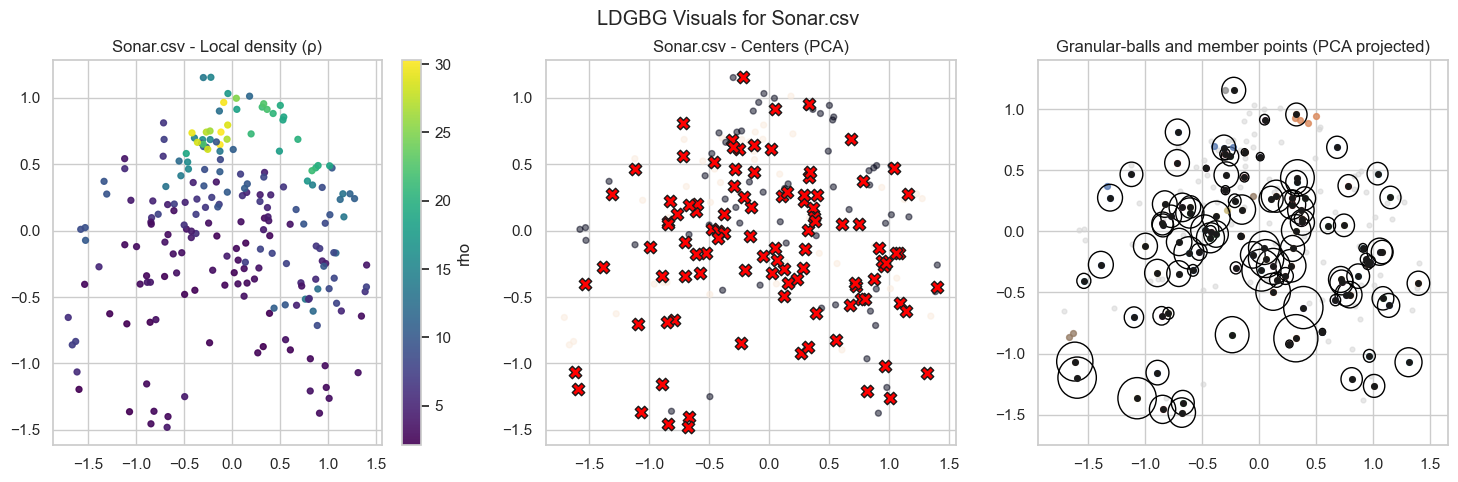

Dataset: Zoo.csv
Shape: (101, 17)
Accuracy: 0.9677, Precision: 0.9286, Recall: 0.9524, F1: 0.9238
Robustness (avg noisy acc): 0.9435, per levels: [0.9355 0.9484 0.9484 0.9419]
Stability (1-var accs): 0.9991, accs: [0.9677 1.     1.     1.     0.9677 0.9032 0.9677 0.9677]
Number of Granular Balls: 47


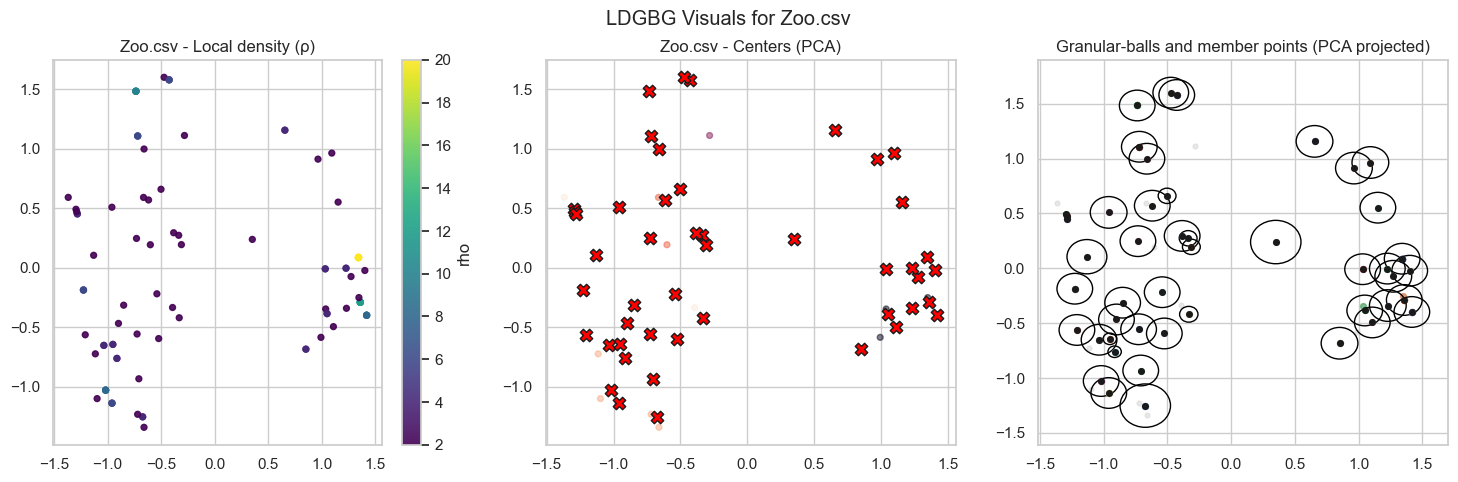

Dataset: seeds.csv
Shape: (210, 8)
Accuracy: 0.9206, Precision: 0.9221, Recall: 0.9205, F1: 0.9209
Robustness (avg noisy acc): 0.8516, per levels: [0.9079 0.8794 0.8381 0.781 ]
Stability (1-var accs): 0.9982, accs: [0.873  0.9048 0.9683 0.9524 0.9683 0.9206 0.873  0.8571]
Number of Granular Balls: 83


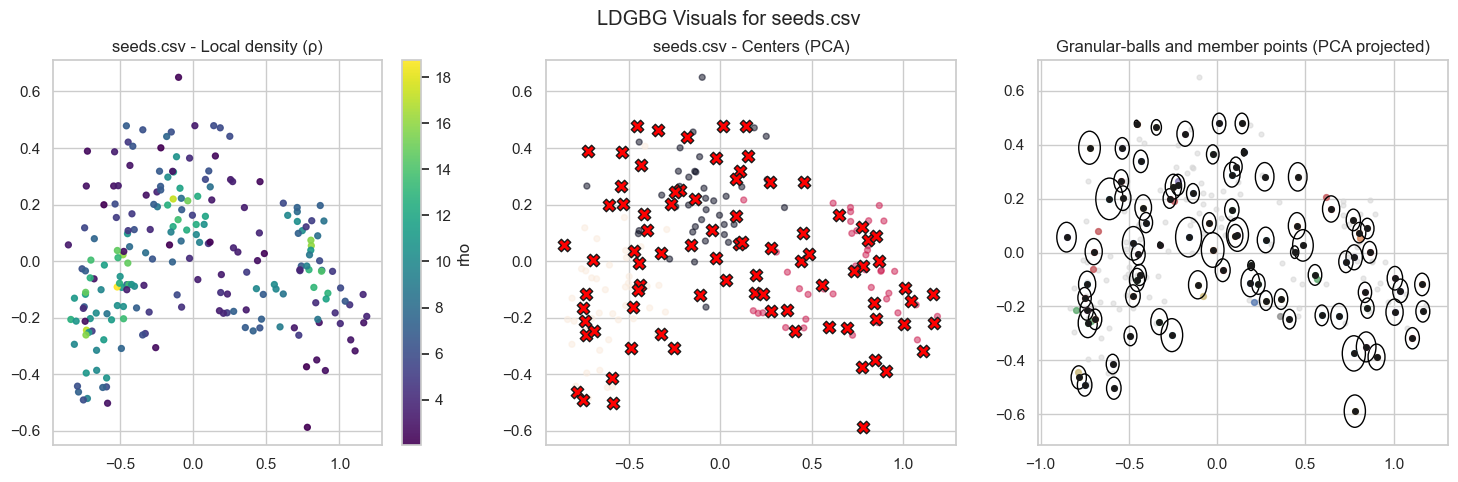

Dataset: dermatology.csv
Shape: (366, 35)
Accuracy: 0.9727, Precision: 0.9679, Recall: 0.9674, F1: 0.9673
Robustness (avg noisy acc): 0.9505, per levels: [0.9745 0.9582 0.9473 0.9218]
Stability (1-var accs): 0.9998, accs: [0.9364 0.9545 0.9727 0.9818 0.9727 0.9727 0.9636 0.9727]
Number of Granular Balls: 167


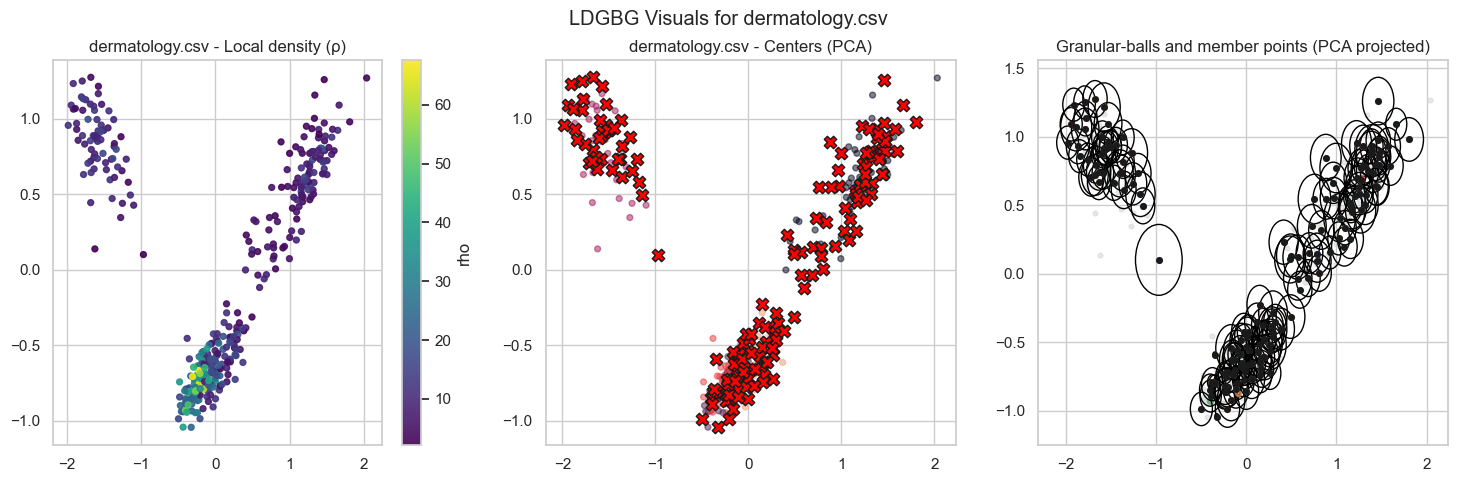

Dataset: breast_cancer.csv
Shape: (699, 11)
Accuracy: 0.9333, Precision: 0.9382, Recall: 0.9074, F1: 0.9206
Robustness (avg noisy acc): 0.9400, per levels: [0.9362 0.941  0.9438 0.939 ]
Stability (1-var accs): 0.9870, accs: [0.9571 0.6095 0.9619 0.9619 0.9429 0.9143 0.9238 0.981 ]
Number of Granular Balls: 44


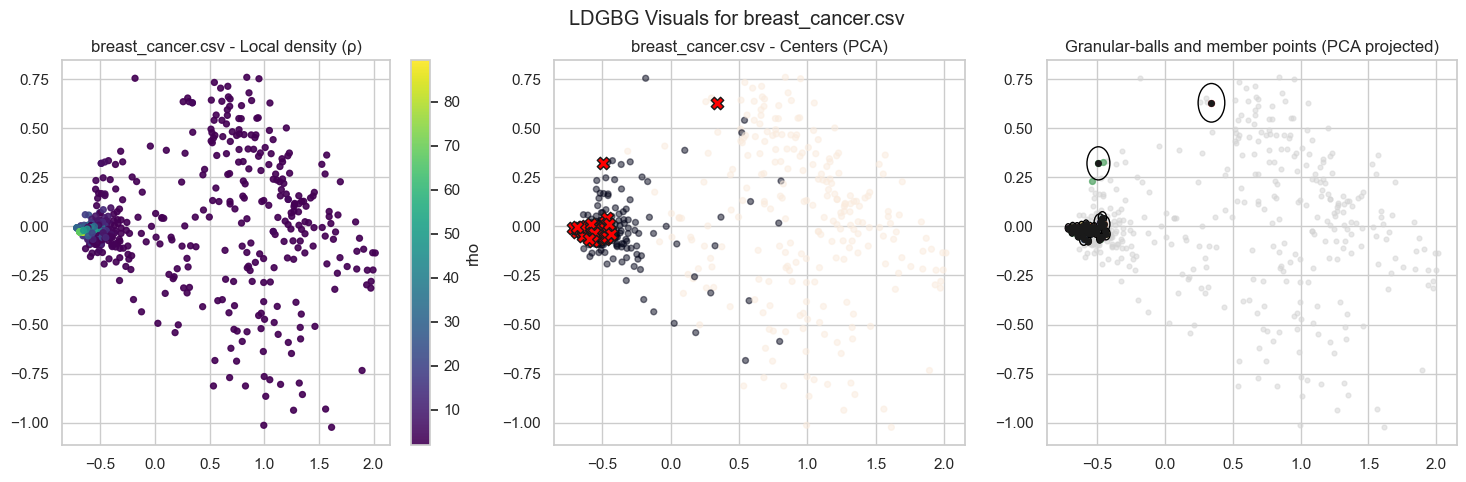

Dataset: ionosphere.csv
Shape: (351, 35)
Accuracy: 0.9528, Precision: 0.9653, Recall: 0.9359, F1: 0.9478
Robustness (avg noisy acc): 0.9349, per levels: [0.9415 0.9491 0.9396 0.9094]
Stability (1-var accs): 0.9994, accs: [0.934  0.9151 0.934  0.9151 0.8868 0.9434 0.8679 0.9245]
Number of Granular Balls: 188


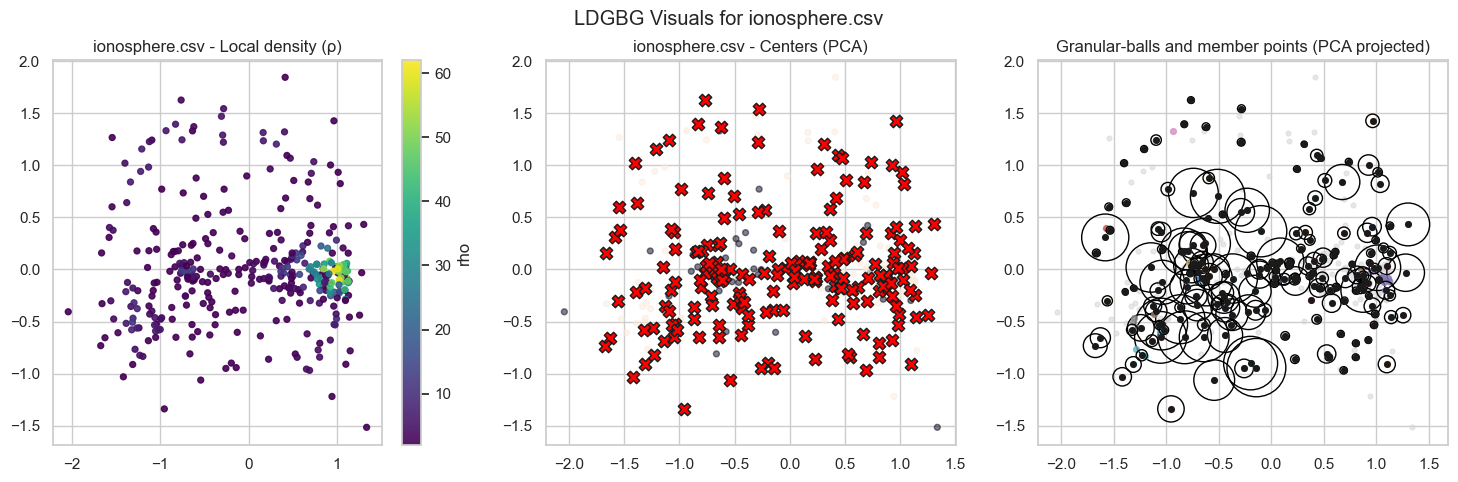

Dataset: Thyroid1.csv
Shape: (3771, 26)
Accuracy: 0.9178, Precision: 0.6703, Recall: 0.5767, F1: 0.6002
Robustness (avg noisy acc): 0.9064, per levels: [0.9233 0.9004 0.8958 0.9064]
Stability (1-var accs): 0.9999, accs: [0.917  0.9258 0.9311 0.9293 0.9276 0.9302 0.9152 0.9055]
Number of Granular Balls: 399


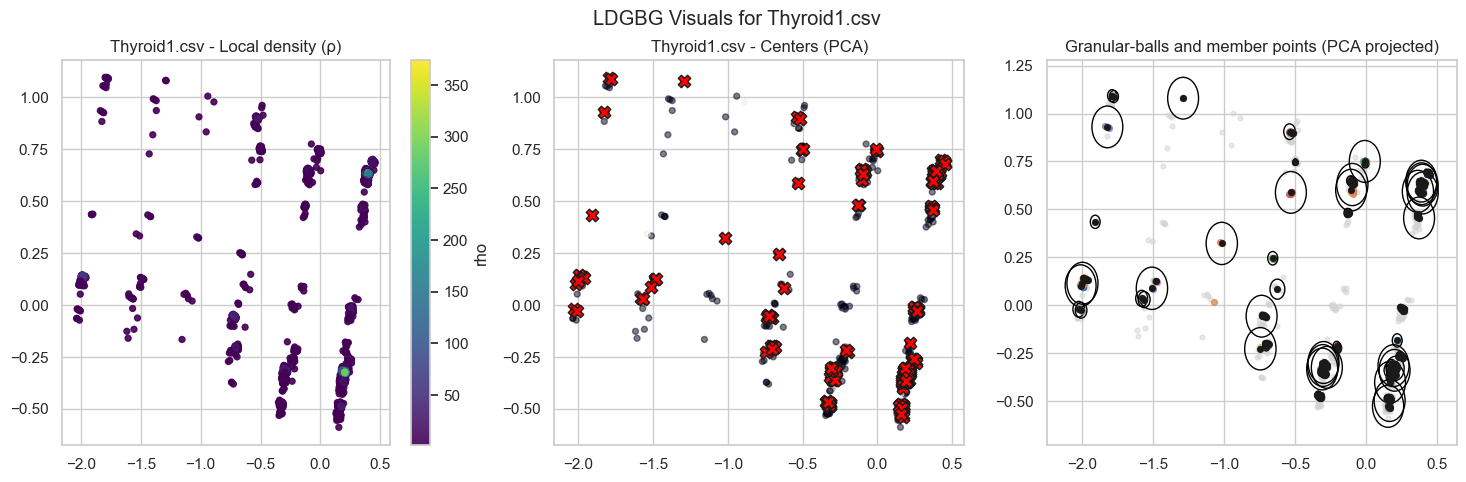


=== Average metrics across datasets ===


accuracy        0.934018
precision       0.895282
recall          0.875443
f1              0.878718
robustness      0.905210
stability       0.997249
num_gbs       147.142857
dtype: float64

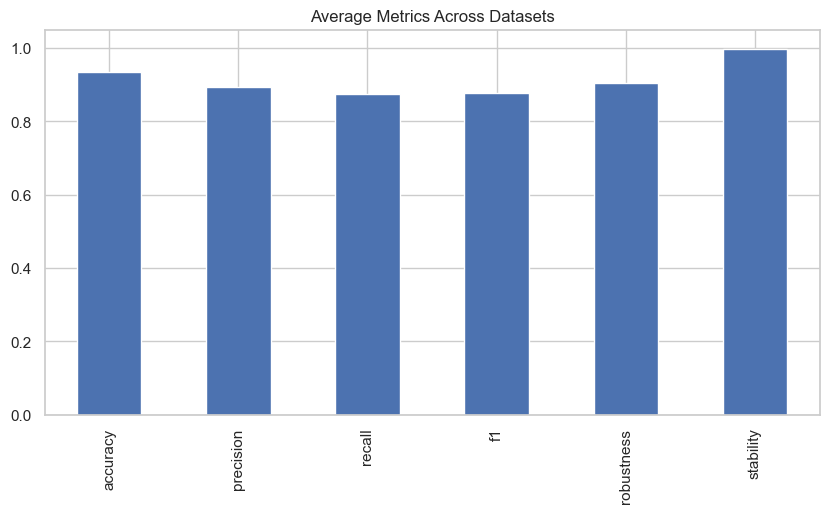

In [9]:
#dataset list
dataset_list = [
    "Sonar.csv",
    "Zoo.csv",
    "seeds.csv",
    "dermatology.csv",
    "breast_cancer.csv",
    "ionosphere.csv",
    "Thyroid1.csv"
]


all_metrics, metrics_df, avg_metrics = evaluate_multiple_datasets(dataset_list, normalize=True)


In [10]:
#Save per-dataset metrics to CSV
metrics_df.to_csv("LDGBG_Data.csv", index=False)
print("Saved metrics to LDGBG_DATA.csv")


Saved metrics to LDGBG_DATA.csv
